In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import tensorflow_hub as hub

객체 인식등 더 정교화된 분류 시스템을 고안해 내기 위해서는 고급 CNN Architecture을 사용하고 이해하는 것이 중요하고, 그에 따라서 전이 학습을 사용할 수 있는 것 또한 중요해진다.  
따라서 이번 notebook에서는  
1. VGG, Inception, ResNet의 원리에 대해 알아보고  
2. 이러한 네트워크들을 직접 구현하고 실습해보고  
3. 전이학습의 정의와 훈련된 network를 다른 용도에 맞게 효율적으로 바꾸는 방법에 대해 알아볼 예정이다.

### AlexNet
- Activation Function으로 **정류형 선형 유닛(ReLU)**를 사용하여 sigmoid나 tanh function보다 경사 소실 문제를 개선하여 학습을 진행한다.  
= CNN에 앞선 장에서 나온 dropout을 적용한다.  
- Convolution과 Pooling layer으로 구성된 블록과 최종 예측을 위한 Dense layer로 구성이된, 앞서 나온 Lenet-5와 매우 흡사한 구조를 가진다.
- 인위적으로 dataset을 늘리기 위해서 원본 샘플을 무작위로 편집해 훈련 이미지의 개수를 늘리고 무작위 변환(이미지 변환, 좌우 변환 등을 이용한다.)  


### VGG Network
- 이는 AlexNet의 한계점을 개선한 network이다.
1. 규모가 큰 합성곱을 여러개의 작은 합성곱으로 대체  
    - 이렇게 하면 매개변수의 개수가 줄어든다는 이점이 존재하게 된다.
        - 11 x 11의 convolution 계층에 n개의 필터를 적용한다는 것은 kernel을 위해서 훈련시켜야 하는 값이 11 x 11 x D x N개라는 것을 의미하기 때문이다.
        - 훈련해야 하는 매개변수의 개수가 줄어든다는 것은 결국 네트워트가 가벼워지면서 최적화를 하기가 쉬워짐을 의미한다.
    - 뿐만 아니라 비선형성을 증가시킨다는 이점이 존재한다.
        - convolution 계층의 개수가 늘어나면, 그리고 각 합성곱 계층 다음에 ReLU와 같은 비선형 활성화 함수가 오면 네트워크의 복잡한 특징을 학습할 수 있는 능력이 증대된다.

2. 특징 맵의 깊이를 증가  
    - 공간 정보를 분류에 사용할 때 더 복잡하고 차별적인 특징으로 인코딩하는 것이 가능해지게 된다.  

3. 척도 변경을 통한 데이터의 보강 
    - 무작위로 이미지의 척도를 변환함으로서 네트워크는 더 다양한 샘플을 경험하게 되고 척도의 변경에도 불구하고 이미지를 분류하는 방법을 학습할 수 있게 된다.
    - 이는 곧 Data Augmentation이라고 부르고 Image Data Generator이나 tf.data.Dataset()을 통해서 충분히 구현이 가능하다.  

4. Dense layer을 Convolution layer로 변경
    - 원래 마지막 층에는 완전 연결 계층인 Dense layer과 softamx 활성화 함수를 이용해서 최종 클래스를 예측하는 것이 일반적이다.
    - 그러나 이 경우에는 크기가 좀 큰 kernel인 7 x 7과 3 x 3을 적용한 함성곱 세트로 특징 맵의 공간의 크기를 1 x 1로 줄이고 특징 맵의 깊이를 4096으로 늘린다.
    - 이렇게 해서 마지막에는 1D의 convolution layer을 사용하여 예측해야 할 클래스의 개수만큼의 filter을 사용한다.
    - 이렇게 하면 1 x 1 x N크기의 벡터는 softmax로 정규화 되고 평면화 되어서 최종 클래스의 확률을 나타낸다.
    

In [3]:
vgg_net = tf.keras.applications.VGG16(
    include_top = True, weights = 'imagenet', input_tensor = None, 
    input_shape = None, pooling = None, classes = 1000
)

553467904/553467096 [==============================] - 73s 0us/step


위에서처럼 이미 훈련이 된 모델을 불러 올 때에 고려해야 할 사항들이 존재한다.  

1. ```include_top = True```를 해주는 부분에서 알아야 할 것은 keras layers에서 제일 위의 계층은 곧 마지막에 출력층을 의미한다.  
    따라서 이 값을 False로 설정하면 dense layer을 제외한 마지막 합성곱 및 max pool layer까지만 출력을 해서 결국에는 이미지의 데이터의 특징을 출력하게 되는 것이다.  
    
2. ```pooling = None```으로 하지 않고 max 나 average로 설정해 주면 다시 학습을 시키겠다는 의미이다.    

In [4]:
vgg_net.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### GoogleLeNet
- 이 network의 주요한 특징은 매개변수의 크기를 크게 늘리지 않고도 학습이 잘 될 수 있도록 하는 Inception modules를 사용했다는 점이다.  
- Inception module이란 다양한 척도를 처리하기 위해서 병렬 계층 블록을 사용해서 깊을 뿐만 아니라 규모가 큰 네트워크를 만들수 있도록 한 것이다.  
    1. 입력 이미지가 맨 처음 일련의 전형적인 convolution layer과 max pooling layer로 이루어진 계층을 통과한다.
        - 여기서 첫 두 층은 계산의 양을 줄이기 위해서 이미지의 높이와 너비를 4배로 줄인다.(면적은 16배 줄어듬)
        - LRN(local response network)이 이전 층의 다양한 특성을 학습하도록 만든다.  

    2. 그런 다음 위의 layer을 통과한 이미지의 추출 데이터는 9개의 Inception Module을 통과하게 된다.
        - 각 module에서 입력 특징 map는 한 두개의 서로 다른 계층(다른 크기의 kernel이 적용된 convolution과 max-pooling으로 구성이 된 4개의 병렬의 하위 블록에 전달이 된다.)
        - 이 4개의 병렬 연산의 결과를 차원의 깊이에 따라 서로 연결해 하나의 feature volume으로 변환하게 된다.  

    3. Inception Module이 나오는 단계가 끝났으면 Average Pooling 층에 의 해 각 특성 맵의 평균을 출력한다. 
        = 여기서 공간 방향의 정보를 전부 잃게 된다.
        - 위치 추정이 아니라 분류 작업이기 떄문에 물체가 어디있는지 중요한 것이 아니기 때문이다.
        - 이렇게 차원 축소를 하게 되면 parameter의 수가 감소하고 과대 적합의 위험도 줄어든다.
        - 동시에 dropout layer 또한 포함하도록 함으로서 gradient loss문제의 해결이 가능하다.
            - 실제로 CNN을 학습하는 중에 깊이가 깊어질수록 경사 손실이 많이 발생한다. (계층의 수가 많을수록 역전파를 할 떄 도함수의 곱이 점점 작아지기 떄문)
        
        

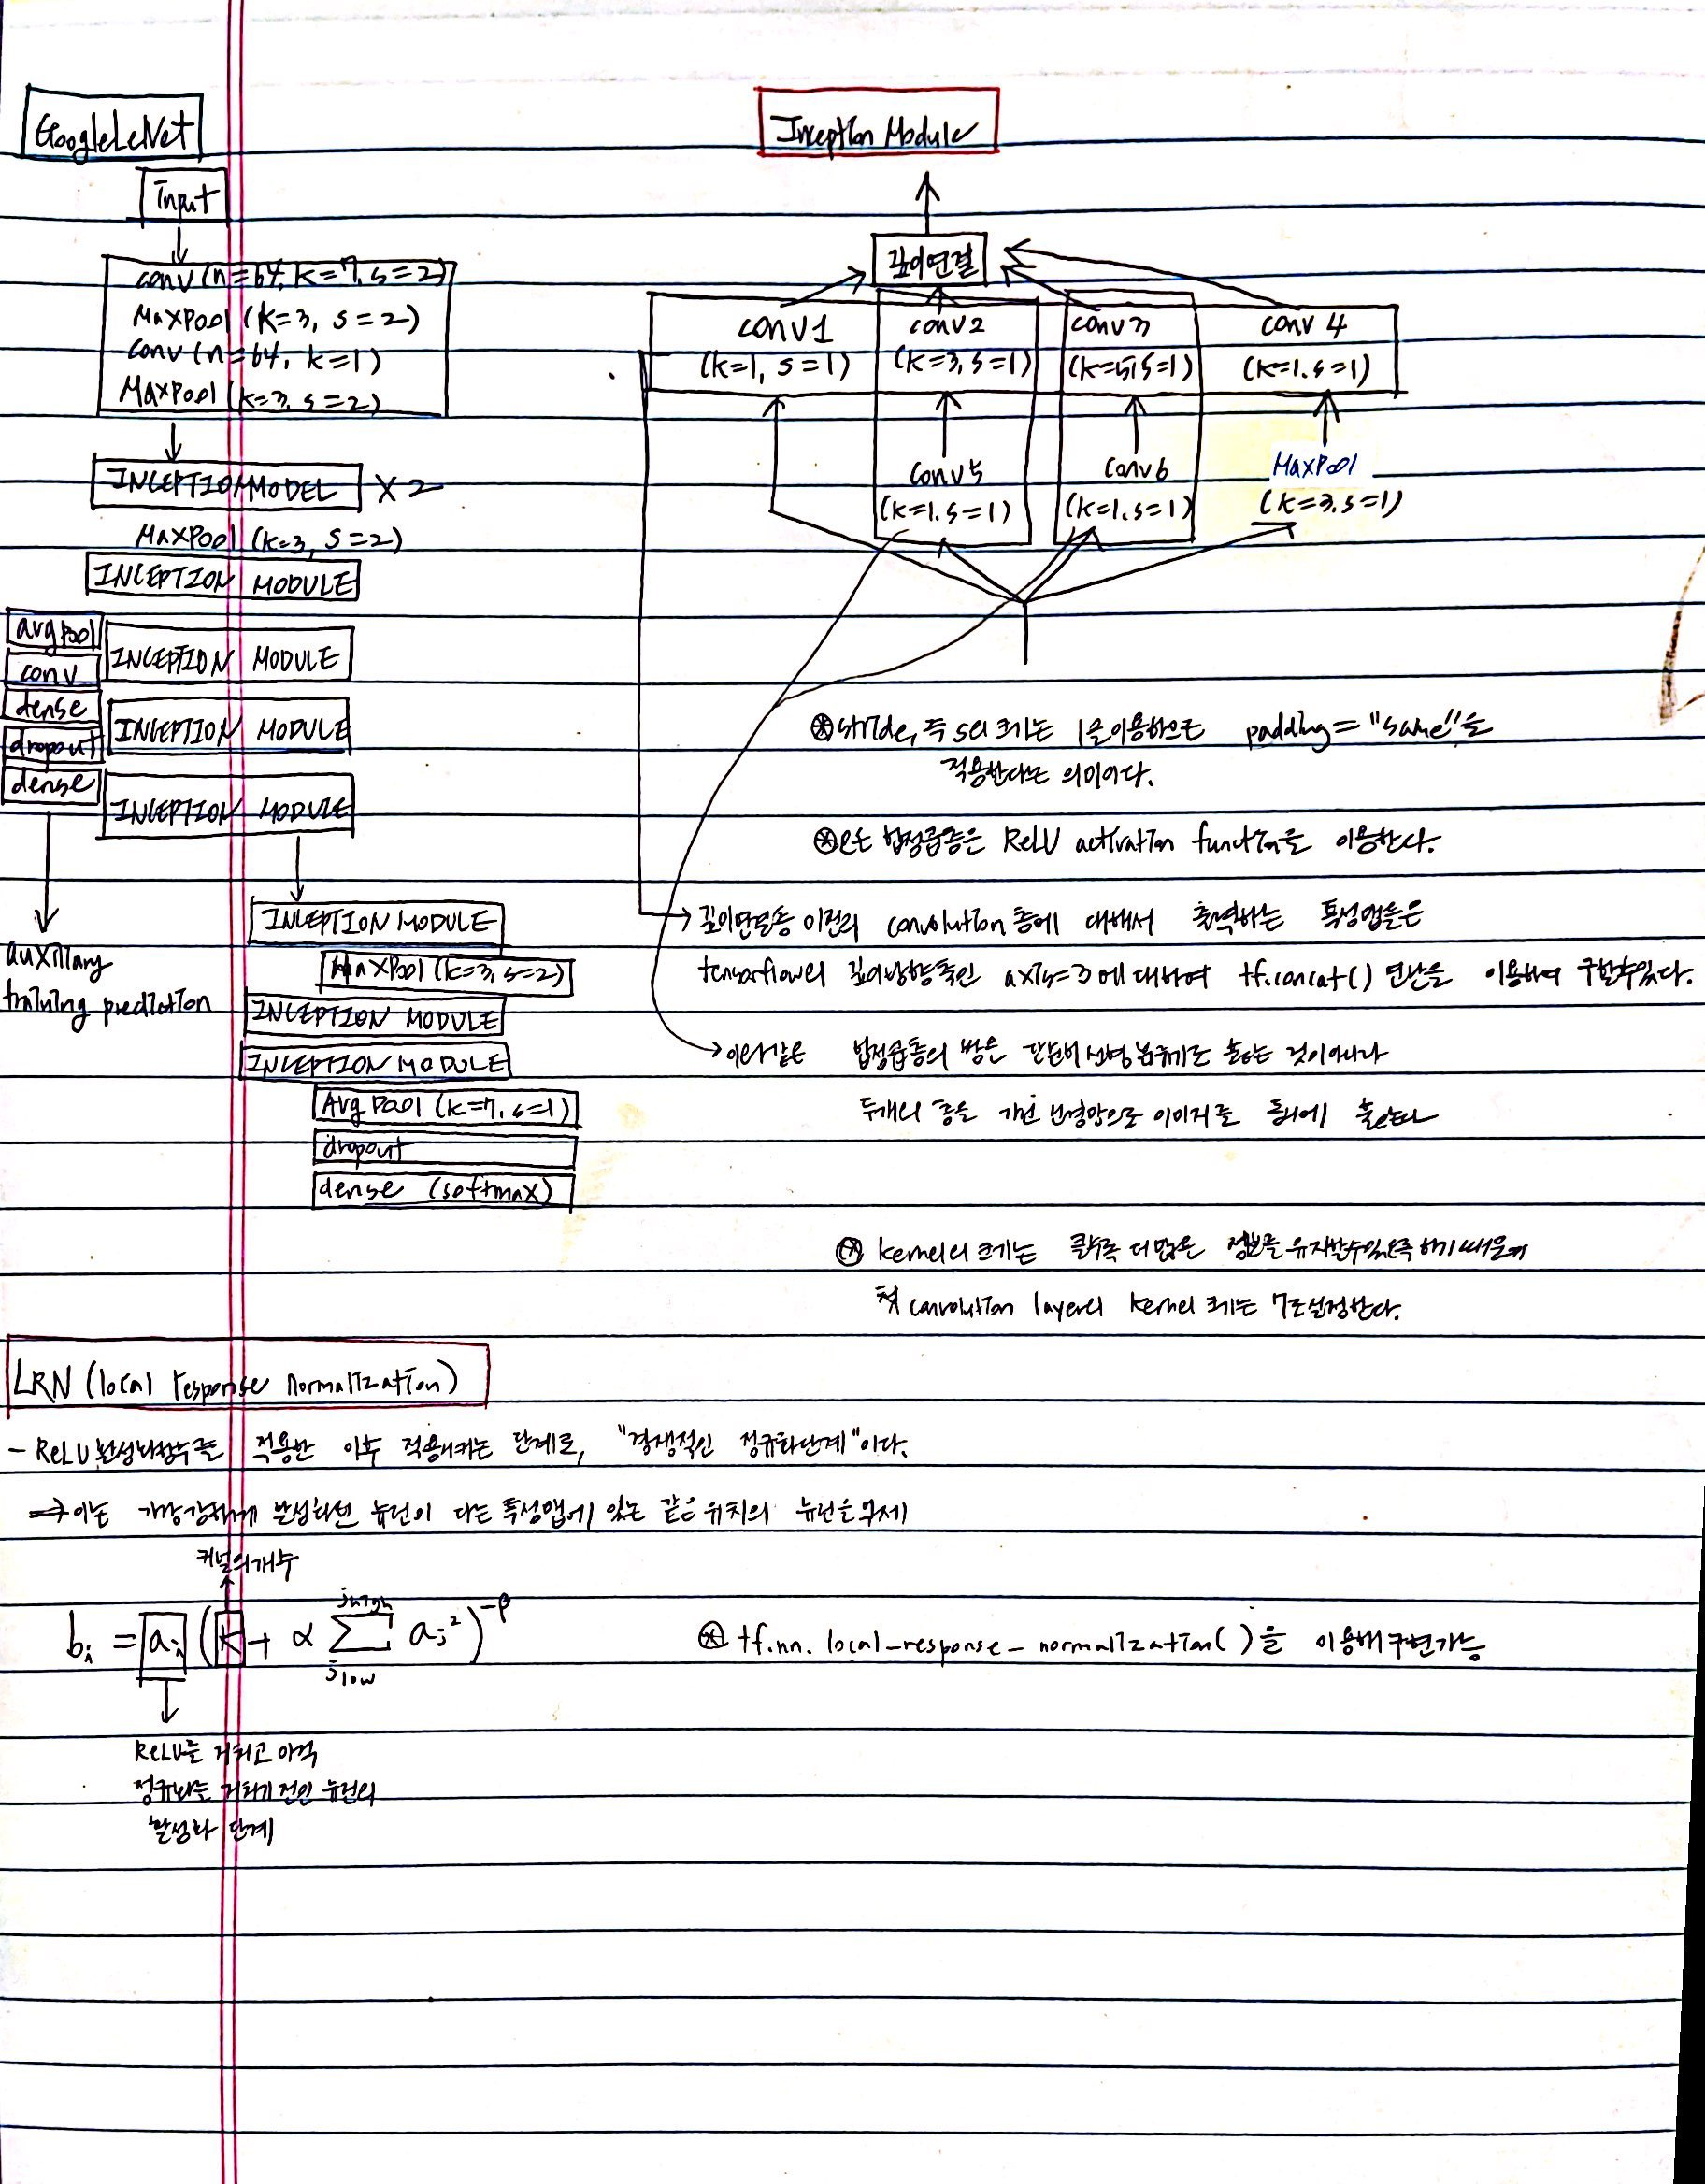

In [85]:
from IPython.display import Image
Image("C:\\Users\\이지혜\\Downloads\\CamScanner 10-14-2020 10.55.57_1.jpg")

In [24]:
def v1_inception_module(previous_layer, filters = [64, 128, 32, 96, 16, 3]):
    convmain1 = tf.keras.layers.Conv2D(filters = filters[0], kernel_size = (1,1), padding = 'same', activation = 'relu')(previous_layer)
    conv1x1 = tf.keras.layers.Conv2D(filters = filters[3], kernel_size = (1,1), padding = 'same', activation = 'relu')(previous_layer)
    conv1x12 = tf.keras.layers.Conv2D(filters = filters[4], kernel_size = (1,1), padding = 'same', activation = 'relu')(previous_layer)
    max_pool = tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = (1,1), padding = 'same')(previous_layer)
    first_inception = tf.keras.layers.concatenate([convmain1, conv1x1, conv1x12, max_pool], axis = 3)
    #여기까지, 즉 first_inception까지 하면 이전의 inception 초기 모델을 만든 것이다.
    convmain2 = tf.keras.layers.Conv2D(filters = filters[0], kernel_size = (1,1), padding = 'same', activation = 'relu')(previous_layer)
    conv3x3 = tf.keras.layers.Conv2D(filters = filters[1], kernel_size = (3,3), padding = 'same', activation = 'relu')(conv1x1)
    conv5x5 = tf.keras.layers.Conv2D(filters = filters[2], kernel_size = (5,5), padding = 'same', activation = 'relu')(conv1x12)
    conv1x13 = tf.keras.layers.Conv2D(filters = filters[2], kernel_size = (1,1), padding = 'same', activation = 'relu')(max_pool)
    return tf.keras.layers.concatenate([convmain2, conv3x3, conv5x5, conv1x13], axis = 3)

In [25]:
import tensorflow as tf
inputs = tf.keras.layers.Input(shape = [224,224,3])
conv1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (7,7), strides = 2)(inputs)
maxpool1 = tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 2)(conv1)
conv2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 1, padding = 'same')(maxpool1)
maxpool2 = tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 2)(conv2)



In [26]:
inception_added = v1_inception_module(maxpool2)

In [28]:
inception_added

<tf.Tensor 'concatenate_17/Identity:0' shape=(None, 26, 26, 256) dtype=float32>

In [69]:
class InceptionLayer(tf.keras.layers.Layer):
    #이 inception layer은 두개의 module을 병렬로 연결 지은 것은 아니기 떄문에 원시 inception module로, 조금 단순화 되어 있다.
    def __init__(self, filters = [64, 96, 16],**kwargs):
        super().__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(filters[0], kernel_size = (1,1), padding = 'same', activation = 'relu')
        self.conv2 = tf.keras.layers.Conv2D(filters[1], kernel_size = (1,1), padding = 'same', activation = 'relu')
        self.conv3 = tf.keras.layers.Conv2D(filters[2], kernel_size = (1,1), padding = 'same', activation = 'relu')
        self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 1, padding = 'same')
#layer이나 model을 class를 이용하여 정의 할 때에 call은 이를 불러올때에 사용하게 된다.
#따라서 자연스럽게 input의 값이 정해지게 된다.
#__init__에 넣어주는 값만 사용자가 입력해 주면 되는 parameter이다.
    def call(self, inputs):
        return tf.keras.layers.concatenate([self.conv1(inputs), self.conv2(inputs), self.conv3(inputs), self.maxpool1(inputs)], axis = -1)

In [67]:
LeNet = tf.keras.models.Sequential()
LeNet.add(tf.keras.layers.Conv2D(input_shape = [126,126,3], filters = 64,kernel_size = (7,7), strides = 2, activation = 'relu'))
LeNet.add(tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 2))
LeNet.add(tf.keras.layers.Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu'))
LeNet.add(tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same'))
LeNet.add(InceptionLayer())
LeNet.add(tf.keras.layers.AvgPool2D(pool_size = (7,7), strides = 1, padding = 'same'))
LeNet.add(tf.keras.layers.Dropout(0.3))
LeNet.add(tf.keras.layers.Flatten())
LeNet.add(tf.keras.layers.Dense(10, activation = 'softmax'))

In [68]:
LeNet.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 60, 60, 64)        9472      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 29, 29, 64)        4160      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
inception_layer_14 (Inceptio (None, 15, 15, 240)       11440     
_________________________________________________________________
average_pooling2d_5 (Average (None, 15, 15, 240)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 240)      

In [70]:
#그냥 함수를 이용해서도 inception layer을 정의해 보았는데, 이번에는 원시 inception layer이 아닌 inception module v1이다.
#concantencate를 할 때에는 합쳐주고자 하는 정해주는 axis를 제외한 나머지의 shape의 값이 동일해야한다.
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = tf.keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = tf.keras.layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = tf.keras.layers.Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = tf.keras.layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = tf.keras.layers.Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = tf.keras.layers.MaxPool2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = tf.keras.layers.Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = tf.keras.layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

In [37]:
Input = tf.keras.layers.Input(shape = (224,224,3))
first_layer = inception_module(Input, 64, 96, 128, 16, 32, 32)
second_layer = inception_module(first_layer, 128, 128, 192, 32, 96, 64)
LeNet = tf.keras.models.Model(inputs = Input, outputs = second_layer)
LeNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 224, 224, 96) 384         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 224, 224, 16) 64          input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 224, 224, 3)  0           input_13[0][0]                   
______________________________________________________________________________________________

In [4]:
import tensorflow_hub as hub
import tensorflow as tf
url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2"
hub_feature_extractor = hub.KerasLayer(
    url, trainable = False, input_shape = (299,299,3), output_shape = (2048,), dtype = tf.float32
)

In [74]:
inception_model = tf.keras.models.Sequential(
    [hub_feature_extractor, tf.keras.layers.Dense(units = 10, activation = 'softmax')], name = "inception_tf_hub"
)

In [75]:
inception_model.summary()

Model: "inception_tf_hub"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [62]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [63]:
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)

In [64]:
x_train.shape

TensorShape([60000, 28, 28, 1])

In [66]:
x_train.shape, y_train.shape

(TensorShape([60000, 299, 299, 1]), (60000,))

In [67]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().batch(32)

In [ ]:
inception_model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['accuracy'])
inception_model.fit(x = x_train, y = y_train,sample_weight = None, batch_size = 32, epochs = 5)

위와 같이 간단한 fashion mnist dataset을 이용하려 했었으나 이는 channel의 크기가 흑백이기 때문에 3이아닌 1이다.  
그러나 inception_model은 (299, 299, 3)의 크기의 이미지 데이터로 학습을 시킨 modeul이고 이와 맞아 떨어지고 이 모듈을 사용하기 위해서는 반드시 이와 상응하는 데이터를 입력값으로 넣어 주어야 한다.  
때문에 내가 fashion_mnist데이터를 resizing을 (299,299,1)로 했음에도 학습에 오류가 생긴 것이다.  


**추가로 tf.image.resize()를 하는데에 있어서 만약 입력하는 이미지의 데이터의 shape가 [Batchsize, width, height, channel]이면 4차원의, [width, height, channel]이면 3차원의 데이터를 return해주는데 이 경우에는 6000이 곧 batchsize였기 떄문에 tf.expand_dims(axis = -1)을 해서 차원 방향으로 확장을 해 주어야 했었다.**

### ResNet
- ResNet는 **잔차 네트워크 (residual network)**를 사용하여 만든 모델이다.
- 이의 원조는 152개의 층으로 구성이 된 매우 깊은 CNN을 사용한다. (물론 가벼운 데이터를 다루기 위해서 34, 50, 101개의 층을 가지고도 충분히 만들 수 있다.)
    - 이렇게 더 적은 parameter을 이용해서 점점 더 깊은 network로 모델을 구성하는것의 시작이 되었다.
    - 이런 깊은 네트워크를 훈련 시킬 수 있었던 제일 중요한 요소는 **Skip Connection**이다.
        - 즉, 어떤 층에 주입되는 신호가 상위의 층의 출력에도 더해지게 되는 것이다.
    - 이 네트워크에서 사용하는 알고리즘은 GoogleLeNet과 비슷하지만, 각 병렬 계층이 입력 정보를 비선형적으로 처리하는 inception layer과 달리 residual block는 하나의 비선형 경로와 하나의 항등 경로로 구성이 된다.
        - 비선형 경로는 batch normalization과 ReLU활성화 함수와 함께 두개의 convolution layer을 입력 특징에 적용한다.
        - 항등 경로는 어떤 변환도 적용하지 않고 그냥 특징을 다음 layer에 전달하는 과정을 거친다.
    - CNN에 잔차 블록을 추가하면 처리 분기의 가중치를 0으로 설정해 사전 정의된 랑등 매핑만 남겨서 원래의 성능을 유지할 수 있다.
    - 따라서 처리 경로는 손실 최소화 효과가 있을 경우만 고려하게 된다.

1. 데이터의 전달 경로는 일반적으로 skip이라고 부르고 처리 경로는 residual path, 즉 잔차 경로라고 부른다.
    - 그 이유는 경로의 연산의 출력을 원본 입력에 더하는데, 이때 항등 매핑이 최적값에 가까울 때에 처리된 tensor의 크기가 입력 tensor보다 작기 떄문이다.
    - 따라서 이 잔차 경로는 입력 데이터에 약간의 변화만 가져오기 때문에 더 깊은 계층으로 패턴의 전달이 가능하다.
2. 잔차 블록은 또한 매개 변수도 많지 않다.
    - 그냥 일반적인 덧셈 연산을 구현하기 때문이다.            

**CNN Network를 구현함에 있어서 제일 중요한 것은 네트워크의 계층이 항등 매핑(Identity Mapping)을 쉽게 학습하는 것이다.**
- 즉, 계층이 가중치를 학습해서 계층에서의 계산이 최종적으로 입력 텐서와 동일한 텐서를 반환해야만 손실이 발생하지 않을 것이라는 의미이다.
    1. 일부 추가적인 convolution계층을 사용하여 데이터를 추가로 처리
    2. 항등 매핑(어떠한 변경 없이 전달 수행)
- 위의 두가지 경로를 이용하여 잔차 블록을 도입하는 것이 ResNet의 원리이다.        

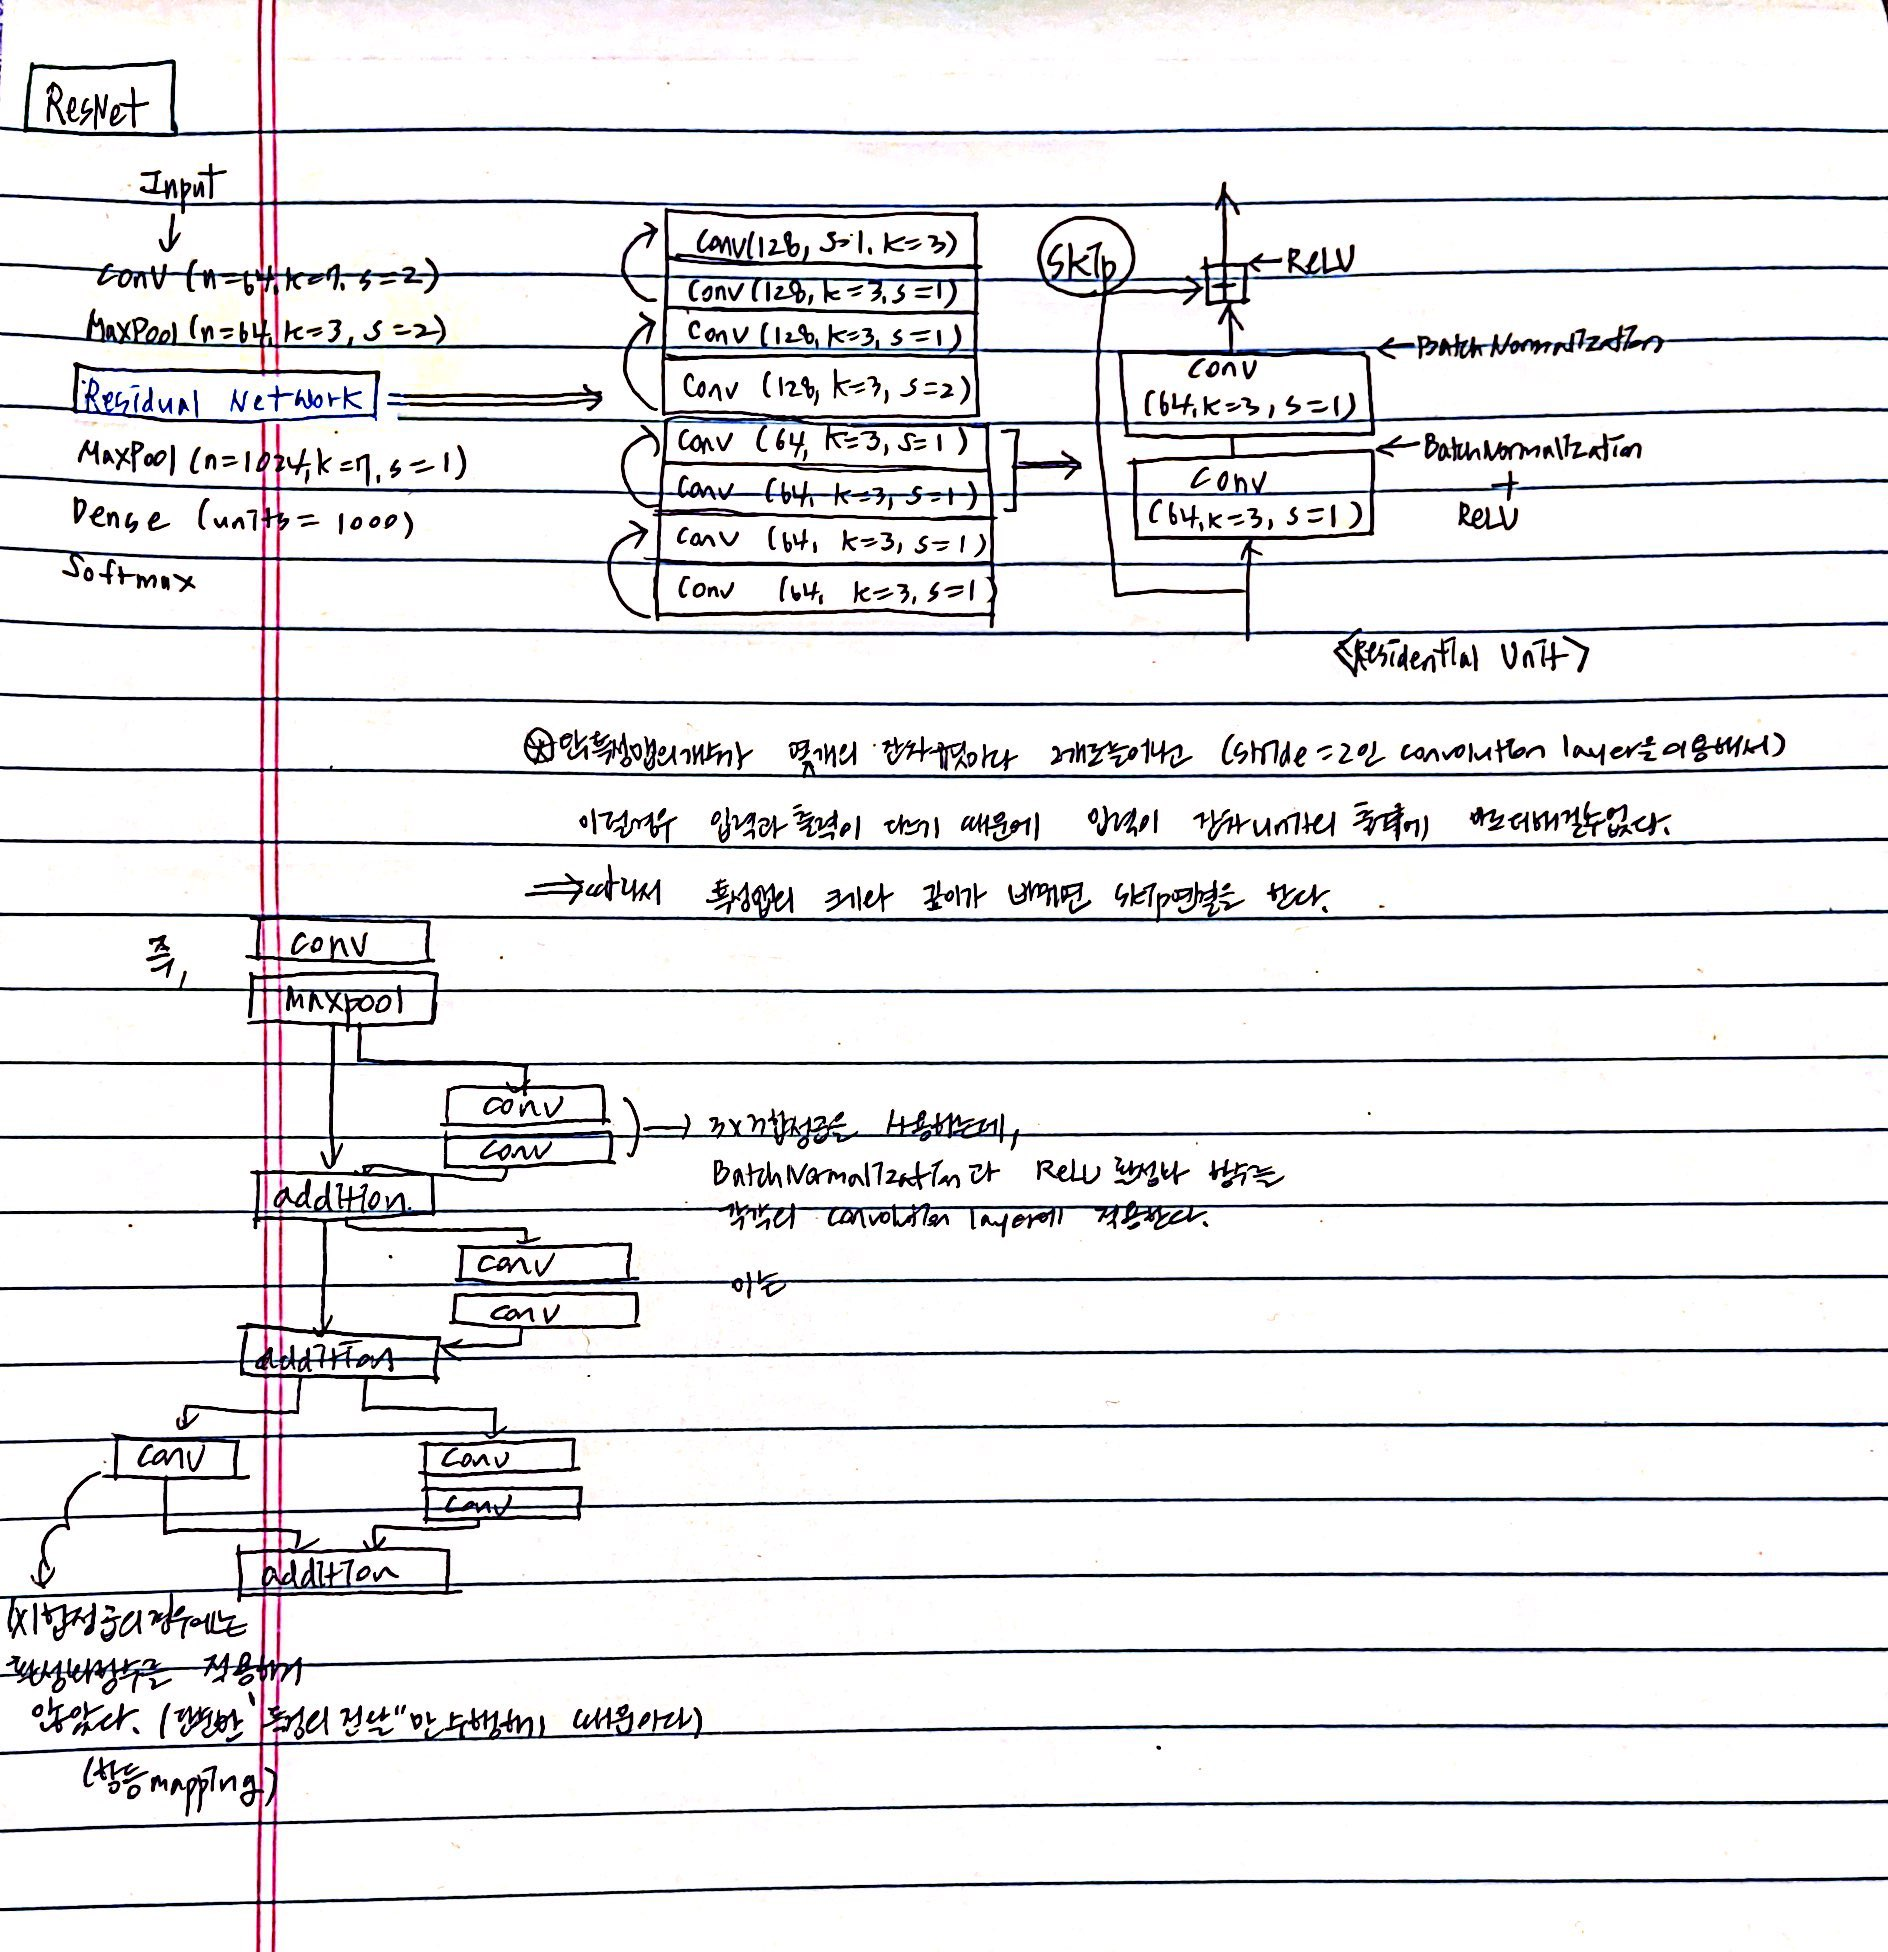

In [79]:
from IPython.display import Image
Image("C:\\Users\\이지혜\\Downloads\\CamScanner 10-14-2020 23.20.52_1.jpg")

In [75]:
#사용자 정의 모델(keras를 이용해서 만든 것이므로 나중에 keras의 Sequential model에 adding을 할 수 있다.)
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides = 1, activation = 'relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        #잔차 경로인 main_layer은 3x3 convolution layer, Batch Normalization, ReLU activation function 사용
        self.main_layers = [
            tf.keras.layers.Conv2D(filters = filters, kernel_size = (3,3), strides = strides, padding = 'same', use_bias = False),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            tf.keras.layers.Conv2D(filters = filters, kernel_size = (3,3), strides = 1, padding = 'same', use_bias = False),
            tf.keras.layers.BatchNormalization()]
        #skip_layer는 데이터에 별도의 처리 없이 전달만 (activation function도 없음 -> parameter의 개수를 줄이면서 깊이 학습 가능)
        #가끔 설정에 따라 입력 텐서의 형상의 조절을 위해 1x1 convolution layer도입
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                tf.keras.layers.Conv2D(filters = filters, kernel_size = (1,1), strides = strides, padding = 'same', use_bias = False),
                tf.keras.layers.BatchNormalization()
            ]
    def call(self, inputs):
        #잔차 경로
        z = inputs
        for layer in self.main_layers:
            z = layer(z)
        #숏컷 경로
        skip_z = inputs
        for layer in self.skip_layers:
            skip_z = layer(skip_z)
        #잔차 경로와 숏컷 경로를 통합하여 activation 함수에 넣은 결과 반환
        return self.activation(z + skip_z)

In [76]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64, kernel_size = (7,7), strides = 2, input_shape = [224,224,3], padding = 'same', use_bias = False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same'))
prev_filters = 64
for filters in [64]*3 + [128]*4 : 
    #원래는 [64]*3 + [128]*4 + [256]*6 + [512]*3이지만 내 GPU가 견디지를 못하는 관계로 간소화해서 학습을 시도해 보았다.
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides = strides))
    prev_filters = filters
model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

In [77]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       